In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rqdatac as rq
rq.init()

In [3]:
index_weight = pd.read_json("index_info.json")["weight"]
index_weight

PS    0.444935
V     0.118748
SF    0.156146
SA    0.063499
LC    0.137322
JM   -0.008427
MA    0.087255
AO   -0.007963
SP    0.066873
RU   -0.058390
Name: weight, dtype: float64

In [4]:
si_data = rq.futures.get_dominant_price("SI", frequency="1m").loc["SI"]
si_data

,trading_date,dominant_id,open,close,high,low,total_turnover,volume,open_interest
datetime,,,,,,,,,
2025-07-17 09:01:00,2025-07-17,SI2509,8790.0,8835.0,8900.0,8785.0,0,29940.0,382102.0
2025-07-17 09:02:00,2025-07-17,SI2509,8835.0,8810.0,8840.0,8805.0,0,13657.0,382567.0
2025-07-17 09:03:00,2025-07-17,SI2509,8815.0,8780.0,8825.0,8770.0,0,15123.0,384108.0
2025-07-17 09:04:00,2025-07-17,SI2509,8785.0,8780.0,8785.0,8770.0,0,10343.0,384947.0
2025-07-17 09:05:00,2025-07-17,SI2509,8785.0,8790.0,8790.0,8775.0,0,6106.0,385199.0
...,...,...,...,...,...,...,...,...,...
2025-10-16 14:56:00,2025-10-16,SI2511,8600.0,8600.0,8610.0,8600.0,0,1133.0,133049.0
2025-10-16 14:57:00,2025-10-16,SI2511,8600.0,8600.0,8605.0,8595.0,0,672.0,132872.0
2025-10-16 14:58:00,2025-10-16,SI2511,8605.0,8605.0,8610.0,8600.0,0,749.0,132742.0


In [5]:
def preprocess(data: tuple):

    minute_price = data["close"]
    minute_price.loc[data["trading_date"].iloc[0] + pd.Timedelta(hours=9)] = data["open"].iloc[0]
    minute_price = minute_price.sort_index()
    trading_date = minute_price.index.strftime("%Y-%m-%d")
    mask = (minute_price.index >= pd.to_datetime(trading_date + " 09:00:00")) & \
           (minute_price.index <= pd.to_datetime(trading_date + " 15:00:00"))
    minute_price = minute_price[mask]

    return minute_price

In [6]:
def preprocess_vwap(data: tuple):

    minute_vwap = (data["close"] * data["volume"]).cumsum() / data["volume"].cumsum()
    minute_vwap.loc[data["trading_date"].iloc[0] + pd.Timedelta(hours=9)] = data["open"].iloc[0]
    minute_vwap = minute_vwap.sort_index()
    trading_date = minute_vwap.index.strftime("%Y-%m-%d")
    mask = (minute_vwap.index >= pd.to_datetime(trading_date + " 09:00:00")) & \
           (minute_vwap.index <= pd.to_datetime(trading_date + " 15:00:00"))
    minute_vwap = minute_vwap[mask]
    minute_vwap = minute_vwap / minute_vwap.iloc[0]

    return minute_vwap

In [7]:
si_minute = si_data.groupby("trading_date").apply(preprocess)
si_minute.name = "SI"
si_val = si_minute.groupby(level=0).apply(lambda x: (((x.diff() / x.shift()).fillna(0) + 1).cumprod())).droplevel(0)
si_val

trading_date  datetime           
2025-07-17    2025-07-17 09:00:00    1.000000
              2025-07-17 09:01:00    1.005119
              2025-07-17 09:02:00    1.002275
              2025-07-17 09:03:00    0.998862
              2025-07-17 09:04:00    0.998862
                                       ...   
2025-10-16    2025-10-16 14:56:00    1.005260
              2025-10-16 14:57:00    1.005260
              2025-10-16 14:58:00    1.005845
              2025-10-16 14:59:00    1.005260
              2025-10-16 15:00:00    1.005845
Name: SI, Length: 13560, dtype: float64

In [8]:
si_vwap = si_data.groupby("trading_date").apply(preprocess_vwap)
si_vwap

trading_date  datetime           
2025-07-17    2025-07-17 09:00:00    1.000000
              2025-07-17 09:01:00    1.005119
              2025-07-17 09:02:00    1.004229
              2025-07-17 09:03:00    1.002846
              2025-07-17 09:04:00    1.002250
                                       ...   
2025-10-16    2025-10-16 14:56:00    1.002378
              2025-10-16 14:57:00    1.002388
              2025-10-16 14:58:00    1.002400
              2025-10-16 14:59:00    1.002408
              2025-10-16 15:00:00    1.002430
Length: 13560, dtype: float64

In [9]:
all_minute = pd.DataFrame()
for underlying in index_weight.index:
    data = rq.futures.get_dominant_price(underlying, frequency="1m").loc[underlying]
    data.to_csv("data/%s.csv" % underlying.lower())
    minute = data.groupby("trading_date").apply(preprocess)
    minute.name = underlying
    all_minute = pd.concat([all_minute, minute], axis=1)

all_minute

PS       V      SF      SA       LC  \
2025-07-17 2025-07-17 09:00:00  46420.0  5078.0  5586.0  1304.0  67180.0   
           2025-07-17 09:01:00  46265.0  5098.0  5604.0  1312.0  67160.0   
           2025-07-17 09:02:00  46135.0  5098.0  5608.0  1313.0  66960.0   
           2025-07-17 09:03:00  46065.0  5094.0  5600.0  1312.0  66960.0   
           2025-07-17 09:04:00  46180.0  5090.0  5586.0  1311.0  66860.0   
...                                 ...     ...     ...     ...      ...   
2025-10-16 2025-10-16 14:57:00  55185.0  4690.0  5450.0  1232.0  74560.0   
           2025-10-16 14:58:00  55170.0  4691.0  5450.0  1233.0  74640.0   
           2025-10-16 14:59:00  54925.0  4692.0  5450.0  1235.0  74840.0   
           2025-10-16 15:00:00  55050.0  4694.0  5456.0  1235.0  75080.0   
2025-10-17 2025-10-17 09:00:00      NaN  4698.0     NaN  1240.0      NaN   

                                    JM      MA      AO      SP       RU  
2025-07-17 2025-07-17 09:00:00  1010.5  2457.0  3154.0  5566.0  15390.0  
           2025-07-17 09:01:00  1018.5  2462.0  3137.0  5570.0  15450.0  
           2025-07-17 09:02:00  1019.0  2462.0  3133.0  5568.0  15450.0  
           2025-07-17 09:03:00  1018.5  2461.0  3134.0  5568.0  15460.0  
           2025-07-17 09:04:00  1016.5  2460.0  3132.0  5570.0  15450.0  
...                                ...     ...     ...     ...      ...  
2025-10-16 2025-10-16 14:57:00  1174.5  2318.0  2786.0  5146.0  14895.0  
           2025-10-16 14:58:00  1182.5  2319.0  2789.0  5148.0  14890.0  
           2025-10-16 14:59:00  1184.5  2318.0  2790.0  5150.0  14895.0  
           2025-10-16 15:00:00  1185.5  2319.0  2790.0  5152.0  14900.0  
2025-10-17 2025-10-17 09:00:00  1190.5  2314.0  2792.0  5152.0  14880.0  

[13561 rows x 10 columns]

In [10]:
index_val = all_minute.groupby(level=0).apply(lambda x: (((x.diff() / x.shift()).apply(lambda y: y.dot(index_weight), axis=1)).fillna(0) + 1).cumprod()).droplevel(0)
index_val = index_val.rename_axis(["trading_date", "datetime"])
index_val

trading_date  datetime           
2025-07-17    2025-07-17 09:00:00    1.000000
              2025-07-17 09:01:00    0.999808
              2025-07-17 09:02:00    0.998291
              2025-07-17 09:03:00    0.997182
              2025-07-17 09:04:00    0.997602
                                       ...   
2025-10-16    2025-10-16 14:57:00    1.023436
              2025-10-16 14:58:00    1.023559
              2025-10-16 14:59:00    1.021995
              2025-10-16 15:00:00    1.023745
2025-10-17    2025-10-17 09:00:00    1.000000
Length: 13561, dtype: float64

In [11]:
val_diff = index_val.reindex(si_val.index) - si_val
counts, bin_edges = np.histogram(val_diff, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def normal_func(x, mu, sigma, amplitude):
    return amplitude * norm.pdf(x, mu, sigma)

# 使用曲线拟合
params, params_covariance = optimize.curve_fit(
    normal_func, bin_centers, counts, p0=[val_diff.mean(), val_diff.std(), counts.max()]
)

print(f"拟合参数: μ={params[0]:.6f}, σ={params[1]:.6f}, 幅度={params[2]:.6f}")

拟合参数: μ=0.000469, σ=0.010692, 幅度=11.230873


In [12]:
confidence_levels = [0.10, 0.20, 0.30]  # 10%, 20%, 30%水平

print("标准正态分布的单边分位数:")
for level in confidence_levels:
    z_score = norm.ppf(1 - level)  # ppf是分位数函数
    print(f"{int(level*100)}%水平: μ + {z_score:.4f}σ")

标准正态分布的单边分位数:
10%水平: μ + 1.2816σ
20%水平: μ + 0.8416σ
30%水平: μ + 0.5244σ


In [13]:
si_val.name = "si"
index_val.name = "index"
val_diff.name = "spread"

data = pd.concat([val_diff, si_val, index_val], axis=1)
data

spread        si     index
trading_date datetime                                         
2025-07-17   2025-07-17 09:00:00  0.000000  1.000000  1.000000
             2025-07-17 09:01:00 -0.005311  1.005119  0.999808
             2025-07-17 09:02:00 -0.003984  1.002275  0.998291
             2025-07-17 09:03:00 -0.001680  0.998862  0.997182
             2025-07-17 09:04:00 -0.001260  0.998862  0.997602
...                                    ...       ...       ...
2025-10-16   2025-10-16 14:57:00  0.018176  1.005260  1.023436
             2025-10-16 14:58:00  0.017715  1.005845  1.023559
             2025-10-16 14:59:00  0.016735  1.005260  1.021995
             2025-10-16 15:00:00  0.017901  1.005845  1.023745
2025-10-17   2025-10-17 09:00:00       NaN       NaN  1.000000

[13561 rows x 3 columns]

In [14]:
def add_lag(data: pd.DataFrame):
    for lag in range(1, 3):
        data["si_lag_%d" % lag] = data["si"].shift(lag)
        data["index_lag_%d" % lag] = data["index"].shift(lag)
    return data

lag_data = data.groupby(level=0).apply(add_lag).droplevel(0).dropna(how="any")
lag_data

spread        si     index  si_lag_1  \
trading_date datetime                                                      
2025-07-17   2025-07-17 09:02:00 -0.003984  1.002275  0.998291  1.005119   
             2025-07-17 09:03:00 -0.001680  0.998862  0.997182  1.002275   
             2025-07-17 09:04:00 -0.001260  0.998862  0.997602  0.998862   
             2025-07-17 09:05:00 -0.002100  1.000000  0.997900  0.998862   
             2025-07-17 09:06:00 -0.000596  0.999431  0.998835  1.000000   
...                                    ...       ...       ...       ...   
2025-10-16   2025-10-16 14:56:00  0.017853  1.005260  1.023113  1.006429   
             2025-10-16 14:57:00  0.018176  1.005260  1.023436  1.005260   
             2025-10-16 14:58:00  0.017715  1.005845  1.023559  1.005260   
             2025-10-16 14:59:00  0.016735  1.005260  1.021995  1.005845   
             2025-10-16 15:00:00  0.017901  1.005845  1.023745  1.005260   

                                  index_lag_1  si_lag_2  index_lag_2  
trading_date datetime                                                 
2025-07-17   2025-07-17 09:02:00     0.999808  1.000000     1.000000  
             2025-07-17 09:03:00     0.998291  1.005119     0.999808  
             2025-07-17 09:04:00     0.997182  1.002275     0.998291  
             2025-07-17 09:05:00     0.997602  0.998862     0.997182  
             2025-07-17 09:06:00     0.997900  0.998862     0.997602  
...                                       ...       ...          ...  
2025-10-16   2025-10-16 14:56:00     1.021990  1.005845     1.021124  
             2025-10-16 14:57:00     1.023113  1.006429     1.021990  
             2025-10-16 14:58:00     1.023436  1.005260     1.023113  
             2025-10-16 14:59:00     1.023559  1.005260     1.023436  
             2025-10-16 15:00:00     1.021995  1.005845     1.023559  

[13440 rows x 7 columns]

In [15]:
X = lag_data.drop(["spread", "si", "index"], axis=1)
X = sm.add_constant(X)
y = lag_data["si"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     si   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.263e+05
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:57:05   Log-Likelihood:                 67770.
No. Observations:               13440   AIC:                        -1.355e+05
Df Residuals:                   13435   BIC:                        -1.355e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0018      0.001      1.537      

In [16]:
(val_diff.groupby(level=0).apply(lambda x: adfuller(x)[1]) < 0.05).sum()

11

In [17]:
((si_val - si_vwap).fillna(method="bfill").groupby(level=0).apply(lambda x: adfuller(x)[1]) < 0.05).sum()

8

In [18]:
def daily_series(panel: pd.DataFrame, diff: bool=False):
    all_daily = pd.DataFrame()
    for data in panel.groupby(level=0):
        daily = data[1].droplevel(0)
        daily.name = daily.index[0].strftime("%Y%m%d")
        daily.index = daily.index.map(lambda x: x.strftime("%H%M%S"))
        all_daily = pd.concat([all_daily, daily], axis=1)
    if diff:
        all_daily = all_daily.diff().dropna()
    return all_daily.reset_index(drop=True)

In [19]:
def long_data_export(all_daily: pd.DataFrame):
    all_daily_long = all_daily.stack().reset_index()
    all_daily_long.columns = ["time", "date", "value"]
    all_daily_long["date"] = pd.to_datetime(all_daily_long["date"])
    all_daily_long = all_daily_long.sort_values(by=["date", "time"]).reset_index(drop=True)
    all_daily_long.to_csv("si_daily_minute.csv")

In [20]:
long_data_export(daily_series(val_diff))

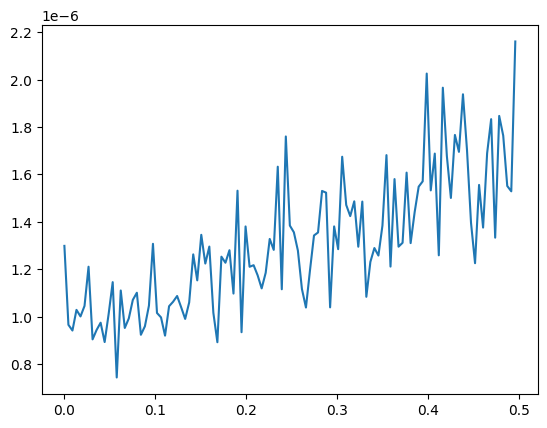

In [21]:
panel = daily_series(val_diff)

def spectral_analysis(series: pd.Series):
    fft_result = np.fft.fft(series.diff().dropna())
    n = len(panel.index)
    freq = np.fft.fftfreq(n)
    psd = np.abs(fft_result) ** 2 / n
    return pd.Series(psd[: n//2], index=freq[: n//2])

average_spectral_power = panel.apply(spectral_analysis).mean(axis=1)
plt.plot(average_spectral_power)
plt.show()

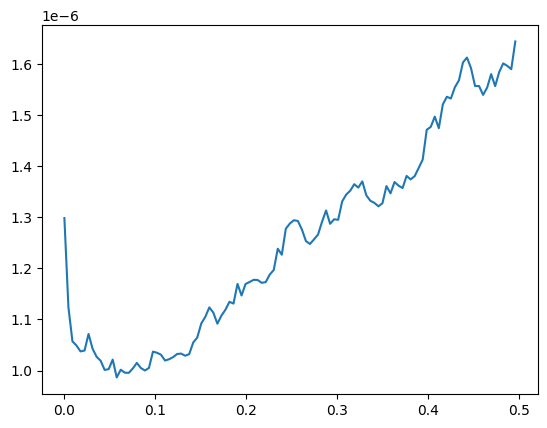

In [22]:
plt.plot(average_spectral_power.ewm(span=20, ignore_na=True).mean())
plt.show()

In [23]:
model = ARIMA(val_diff, order=(1, 0, 1))
print(model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                 spread   No. Observations:                13560
Model:                 ARIMA(1, 0, 1)   Log Likelihood               68063.337
Date:                Fri, 17 Oct 2025   AIC                        -136118.675
Time:                        08:57:10   BIC                        -136088.615
Sample:                             0   HQIC                       -136108.652
                              - 13560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.092      0.927      -0.003       0.003
ar.L1          0.9924      0.001    751.720      0.000       0.990       0.995
ma.L1         -0.0649      0.003    -24.690      0.0

In [24]:
val_diff.groupby(level=0).std().mean()

0.005135756564363917

In [25]:
(si_val - si_vwap).groupby(level=0).std().mean()

0.005370904473042509

In [26]:
intra_chg = si_data.groupby("trading_date").apply(lambda x: x["close"].iloc[-1] - x["open"].iloc[3]).iloc[1:]
daily_chg = si_data.groupby("trading_date")["close"].last().diff().dropna()
intra_prop = intra_chg / daily_chg
intra_prop = intra_prop[~np.isinf(intra_prop)].iloc[:-1]
intra_prop.describe()

count    57.000000
mean      0.837165
std       1.401383
min      -4.750000
25%       0.400000
50%       0.918033
75%       1.368421
max       3.857143
dtype: float64

In [27]:
y = intra_chg
X = daily_chg
X = sm.add_constant(X)

print(sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 10}).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     367.3
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           1.61e-26
Time:                        08:57:10   Log-Likelihood:                -355.59
No. Observations:                  59   AIC:                             715.2
Df Residuals:                      57   BIC:                             719.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.2895      8.207      2.960      0.0

<Axes: xlabel='trading_date'>

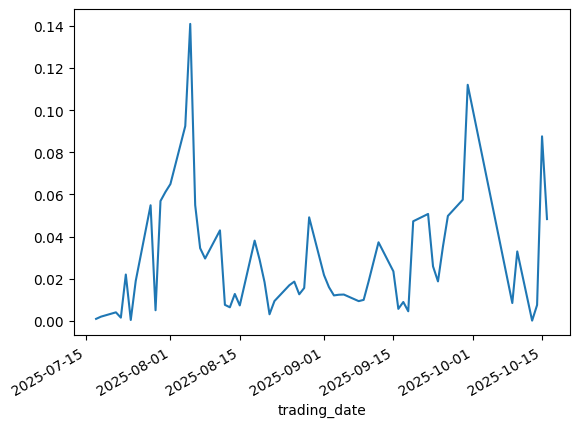

In [28]:
vol2oi = si_data.groupby("trading_date").apply(lambda x: abs(x["open_interest"].iloc[-1] - x["open_interest"].iloc[0]) / x["volume"].sum())
vol2oi.plot()

In [29]:
windows = 3
rol_std = si_data.groupby("trading_date")["close"].apply(lambda x: x.rolling(windows).std().dropna())
rol_vol = si_data.groupby("trading_date")["volume"].rolling(windows).mean().dropna()

y = rol_std
X = rol_vol
X = sm.add_constant(X)

print(sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 1}).summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     668.0
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          8.96e-144
Time:                        08:57:10   Log-Likelihood:                -43083.
No. Observations:               13380   AIC:                         8.617e+04
Df Residuals:                   13378   BIC:                         8.619e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7044      0.126     37.376      0.0

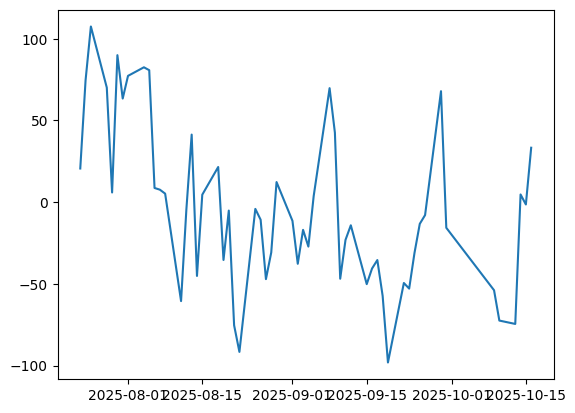

In [30]:
spread = si_minute.groupby(level=0).transform("first") * val_diff
spread = spread.groupby(level=0).apply(lambda x: ((x + x.shift()) / 2).dropna()).droplevel([0, 1])
vw_spread = spread * si_data["volume"]
vw_spread = vw_spread.groupby(vw_spread.index.date).apply(lambda x: x.cumsum()) / si_data["volume"].groupby(si_data.index.date).apply(lambda x: x.cumsum())

def discnt_sum(series: pd.Series):
    n = len(series)
    discnt = pd.Series([np.exp(0.5*i) for i in range(n)], index=series.index)
    discnt = discnt / discnt.sum()
    return (series * discnt).sum()

cum_diff = vw_spread.groupby(level=0).last().rolling(5).apply(discnt_sum).dropna()
plt.plot(cum_diff)
plt.show()

In [31]:
def regression(si_series: pd.Series):
    y = si_series
    X = (index_val.diff() / index_val.shift()).reindex(si_series.index)
    X = sm.add_constant(X)
    return sm.OLS(y, X).fit().params["index"]

beta = (si_val.diff() / si_val.shift()).groupby(level=0).rolling(5).apply(regression).droplevel(0).dropna()
beta

trading_date  datetime           
2025-07-17    2025-07-17 09:05:00    2.516885
              2025-07-17 09:06:00    1.509491
              2025-07-17 09:07:00    1.140819
              2025-07-17 09:08:00    0.732699
              2025-07-17 09:09:00    0.749148
                                       ...   
2025-10-16    2025-10-16 14:56:00    0.617507
              2025-10-16 14:57:00    0.506545
              2025-10-16 14:58:00   -0.134468
              2025-10-16 14:59:00    0.064617
              2025-10-16 15:00:00    0.146113
Name: si, Length: 13319, dtype: float64

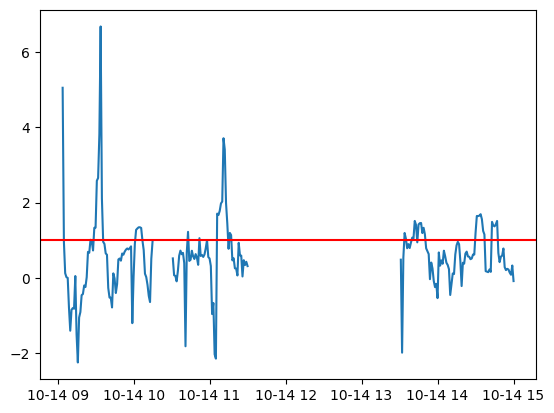

In [32]:
test_beta = beta.xs(pd.to_datetime("20251014"), level=0).asfreq("1min")

plt.plot(test_beta)
plt.axhline(1, color="red")
plt.show()

In [33]:
volume = si_data["volume"]
rol_vol = volume.groupby(volume.index.date).rolling(5).mean().dropna()

y = beta.reindex(rol_vol.index)
X = rol_vol
X = sm.add_constant(X)
print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                     si   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     201.5
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           2.11e-45
Time:                        08:57:51   Log-Likelihood:                -16789.
No. Observations:               13260   AIC:                         3.358e+04
Df Residuals:                   13258   BIC:                         3.360e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9532      0.010     91.406      0.0

In [34]:
all_y = si_val.diff() / si_val.shift()
all_X = index_val.diff() / index_val.shift()

pos_y = all_y[all_y >= 0]
neg_y = all_y[all_y < 0]
pos_X = all_X[pos_y.index]
neg_X = all_X[neg_y.index]

pos_beta = sm.OLS(pos_y, sm.add_constant(pos_X)).fit().params.iloc[0]
neg_beta = sm.OLS(neg_y, sm.add_constant(neg_X)).fit().params.iloc[0]

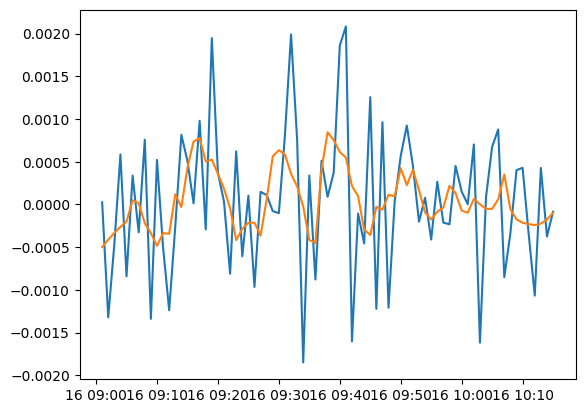

In [67]:
from scipy.signal import savgol_filter

spread = val_diff.xs(pd.to_datetime("20251016"), level=0).iloc[:76].diff().dropna()
smoothed_spread = pd.Series(savgol_filter(spread, window_length=10, polyorder=2), index=spread.index)

plt.plot(spread)
plt.plot(smoothed_spread)
plt.show()

In [68]:
def estimate_rlc(series: pd.Series):
    d1 = series.diff(2) / 2
    d2 = series.diff(1) - series.diff(1).shift(1)
    y = d2.dropna()
    X = pd.concat([d1, series], axis=1).reindex(y.index)
    model = sm.OLS(y, X).fit()
    print(model.summary())
    return model.params

L = 1
thetas = estimate_rlc(spread)
R = -thetas.iloc[0]
C = -1 / thetas.iloc[1]

                                 OLS Regression Results                                
Dep. Variable:                 spread   R-squared (uncentered):                   0.446
Model:                            OLS   Adj. R-squared (uncentered):              0.430
Method:                 Least Squares   F-statistic:                              28.52
Date:                Fri, 17 Oct 2025   Prob (F-statistic):                    8.09e-10
Time:                        10:21:03   Log-Likelihood:                          364.30
No. Observations:                  73   AIC:                                     -724.6
Df Residuals:                      71   BIC:                                     -720.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------